# The Laplace Approximation
The laplace approximation is a widely used framework that finds a Gaussian approximation to a probability density definted over a set of continuous variables. It is especially useful when applying Bayesian principles to logistic regression where computing integral of posterior distributions becomes intractable.

![Laplace Approximation](../../img/LaplaceApproximation.png)

## Basic Idea
Consider a continuous random variable $z \in \mathcal{R}^D$ with probability distribution given by $p(z) = \frac{1}{Z}f(z)$ where $Z = \int{f(z) dz}$ is the normalizing constant and need not be known.

In the Laplace approximation, the goal is to `find a Gaussian distribution q(z) centered on a mode of the p(z)`. The mode can be computed by determining the value of $z=z_0$ where $\frac{dp(z)}{dz} = 0$.

Note that if $p(z)$ is `multi-modal`, the laplace approximation is only precise in the neighborhood of one of its many modes.

Let $q(z) \sim \mathcal{N}(z_0,A^{-1})$ where $A$ is the precision matrix. Note: Precision matrix is the inverse of covariance matrix and is often employed for computational reasons.

$$ \begin{align} q_z &= \frac{\sqrt{|A|}}{(2\pi)^{D/2}} \exp \{-\frac{1}{2}(z-z_0)^T A (z-z_0)\} \\ \Rightarrow \ln{q_z} &= \frac{1}{2} \left(\ln{|A|} - D \ln{2\pi}\right) - \frac{1}{2}(z-z_0)^T A(z-z_0) \\
&= \ln{f_{z0}} - \frac{1}{2}A(z-z_0)^2\end{align}$$

Note that this is a Taylor series expansion for $p_z$ at a mode where $\frac{d \ln p(z)}{dz} = 0$ and $\frac{d^2 \ln p(z)}{dz^2} = -A < 0 \Rightarrow A > 0$.

In summary, the laplace approximation involves evaluating the mode $z_0$ and the Hessian $A$ at $z_0$. So if f(z) has an intractable but analytical form, the mode can be found by some form of numerical optimization algorithm. Note that the normalization constant $Z$ does not need to be known to apply this method.

## Example
This is an example to demonstrate the Laplace approximation and adapted from Figure 4.14 in [1].

Suppose $p(z) \propto \sigma(20z+4) \exp{\left(\frac{-z^2}{2}\right)}$ where $\sigma(\cdot)$ is the sigmoid function. This form is very common in classification problems and serves as a good practical example.

To compute the mode $z_0$ & Hessian $-A$,

$$ \begin{align} \frac{d}{dz}\ln p_z &\propto \frac{d}{dz}\ln \sigma(\cdot) + \frac{d}{dz}\ln \exp{\left(\frac{-z^2}{2}\right)} \\
&= 20 (1-\sigma(\cdot)) - z \\
&= 0 \text{  iff  } z_0 = 20(1-\sigma(20 z_0 + 4))\end{align}$$

The above expression to determine $z_0$ is nonlinear and can be solved by Newton's method.
Let $y(z_0) = z_0 - 20(1-\sigma(20 z_0 + 4))$. To find $z_0$ such that $y=0$, we start with an initial guess $z_{0,0}$ and iterate the following equation till convergence.
$z_{0,k+1} = z_{0,k} - \left(y'(z_{0,k})\right)^{-1} y(z_{0,k})$. The convergence criteria can be either set to a fixed maximum number of iterations or till $|z_{0,k+1} - z_{0,k}| \le \epsilon$ for some small $\epsilon$.

The Hessian is expressed as:

$$ \begin{align} \frac{d^2}{dz^2}\ln p_z &\propto \frac{d}{dz}\frac{d}{dz}\ln p_z  \\
&= -400\sigma(\cdot)(1-\sigma(\cdot)) - 1 \\
\Rightarrow A &= -\Bigg(\frac{d^2}{dz^2}\ln p_z\Bigg)\Bigg\vert_{z=z_0} = 400\sigma(20 z_0 + 4)(1-\sigma(20 z_0 + 4)) + 1\end{align}$$

In [2]:
import numpy as np
from scipy.integrate import trapz
from scipy.stats import norm
import matplotlib.pyplot as plt
import matplotlib
# matplotlib.rcParams['text.usetex'] = True
# matplotlib.rcParams['text.latex.unicode'] = True
%matplotlib inline


def sigmoid(x):
    den = 1.0+np.exp(-x)
    return 1.0/den

def p_z(z):
    p = np.exp(-np.power(z,2)/2)*sigmoid(20*z+4)
    sum_p = trapz(p,z) ## normalize for plotting
    return p,p/sum_p

def findMode(z_init,max_iter = 25,tol = 1E-6):
    iter = 0
    z_next = np.finfo('d').max
    z_cur = z_init
    while (iter < max_iter and np.abs(z_next-z_cur) > tol):
        if iter > 0:
            z_cur = z_next
        y     = z_cur - 20*(1-sigmoid(20*z_cur+4))
        der_y = 1 + 400*sigmoid(20*z_cur+4)*(1-sigmoid(20*z_cur+4))
        z_next = z_cur - y/der_y
        iter = iter+1
#         print("Iter-"+str(iter)+":"+str(z_next))
    return z_next

def getHessian(z):
    sig_x = sigmoid(20*z+4)
    return 400*sig_x*(1-sig_x) + 1

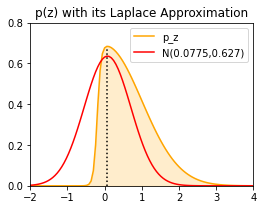

In [3]:
z = np.linspace(-10,10,10000)
pz,pzn = p_z(z)

## Mode & Precision matrix
z0 = findMode(0)
A = getHessian(z0)
z0_idx = np.where(np.abs(z-z0) == np.min(np.abs(z-z0)))[0]
p_z0 = pzn[z0_idx]

dp = np.gradient(pzn,z[1]-z[0])
d2p = np.gradient(dp,z[1]-z[0])

## Get approx Gaussian distribution
q_z = norm.pdf(z, z0, 1/np.sqrt(A))
fig,ax = plt.subplots(1,1,figsize=(4,3))
ax.cla()
ax.plot(z,pzn,color="orange")
ax.fill_between(z,pzn, 0,
                 facecolor="orange", # The fill color
                 color='orange',       # The outline color
                 alpha=0.2)          # Transparency of the fill
#ax.axvline(x=z0)#,ylim=0,ymax=0.7)
ax.vlines(z0, ymin=0, ymax=p_z0,linestyles='dotted')
ax.plot(z,q_z,'r')
ax.set_xlim([-2,4]);
ax.set_ylim([0,0.8]);
ax.set_yticks([0,0.2,0.4,0.6,0.8]);
ax.legend(['p_z','N('+str(np.round(z0,4))+','+str(np.round(1/np.sqrt(A),3))+')'])
ax.set_title('p(z) with its Laplace Approximation');

## References
[1]: Bishop, Christopher M. 2006. Pattern Recognition and Machine Learning. Springer.